Estimate growth rate from online OD data
==

We use Gaussian process regression to estimate the derivative of the optical density time course.

In [1]:
import pandas as pd
print("Pandas version:", pd.__version__)
import matplotlib
from matplotlib import pyplot
print("Matplotlib version:", matplotlib.__version__)
import numpy as np
print("Numpy version:", np.__version__)
import GPy
print("GPy version: ", GPy.__version__)

Pandas version: 1.1.5
Matplotlib version: 3.3.4
Numpy version: 1.19.5
GPy version:  1.10.0


Data is imported from CSV files that are generated by the Matlab scripts for reading the raw data exported from the bioreactor system. We use the calibrated optical density data.

In [2]:
df = pd.read_csv("OD_15062020.csv", sep=',')
time_label = df.columns[0]
od_label = df.columns[1]

In [3]:
df

,Time [h],Calibrated OD [AU]
0,0.021667,0.003319
1,0.096944,0.001992
2,0.171944,0.001328
3,0.247222,0.003983
4,0.322222,0.000664
...,...,...
1748,68.763333,0.448796
1749,68.838333,0.455435
1750,68.846667,0.456763
1751,68.888333,0.449460


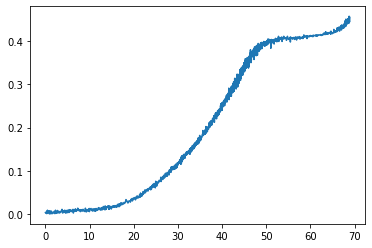

In [4]:
pyplot.plot(df[time_label], df[od_label])

Regression is done with a Gaussian Process with a squared exponential kernel (RBF). The initial length scale is set to 10 hours, but probably the effect of that on the estimation result is not significant. With the data set imported above, the optimization works fine; above 2000 data points it can become computationally inefficient.

In [5]:
kern = GPy.kern.RBF(1, lengthscale=10.0)
gp = GPy.models.GPRegression(np.atleast_2d(df[time_label]).T, np.atleast_2d(df[od_label]).T, kernel=kern)
gp.optimize()
print(gp)


Name : GP regression
Objective : -6942.029018365902
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  rbf.variance             |     0.03677958011247384  |      +ve      |        
  rbf.lengthscale          |      6.5901904892397685  |      +ve      |        
  Gaussian_noise.variance  |  1.9255482238659586e-05  |      +ve      |        


{'dataplot': [<matplotlib.collections.PathCollection at 0x7facf9b06128>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7facf9b06c88>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7facf9b1e2e8>]}

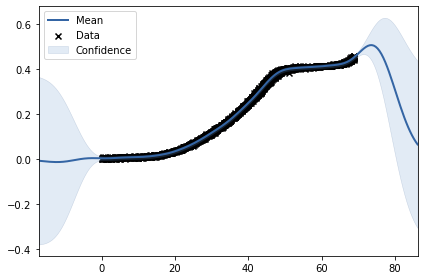

In [6]:
gp.plot()

To estimate the growth rate from the mean function of the GP result, we interpolate the mean function on a fixed grid and take the difference as a numerical approximation to the derivative.

In [7]:
time_grid = np.linspace(0, df[time_label][len(df)-1], num=1000)
od_grid = np.interp(time_grid, df[time_label], gp.posterior.mean.flatten())
mu = np.diff(od_grid) / (time_grid[1]-time_grid[0]) / od_grid[1:]

Text(0, 0.5, 'Growth rate [1/h]')

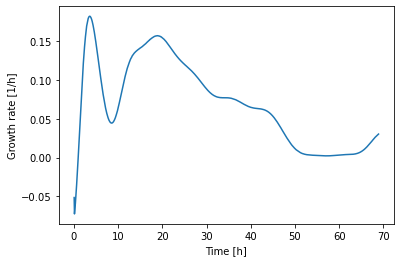

In [8]:
pyplot.plot(time_grid[1:], mu)
pyplot.xlabel("Time [h]")
pyplot.ylabel("Growth rate [1/h]")
# pyplot.plot(time_grid[:-1]/3600, np.diff(od_grid) / time_grid[1] * 3600)

The resulting growth rate is exported together with the original data. For this, the growth rate computed above is again interpolated on the original time grid.

In [9]:
df_with_mu = df.copy()
df_with_mu.insert(2, "Growth rate [1/h]", np.interp(df[time_label], time_grid[1:], mu))

In [10]:
df_with_mu

,Time [h],Calibrated OD [AU],Growth rate [1/h]
0,0.021667,0.003319,-0.051522
1,0.096944,0.001992,-0.060080
2,0.171944,0.001328,-0.070503
3,0.247222,0.003983,-0.065644
4,0.322222,0.000664,-0.060483
...,...,...,...
1748,68.763333,0.448796,0.029616
1749,68.838333,0.455435,0.029997
1750,68.846667,0.456763,0.030028
1751,68.888333,0.449460,0.030185


In [11]:
df_with_mu.to_csv("OD_15062020_with_mu.csv")

Do the steps show above in a single code cell for all data files. We only display the GP regression result and the OD / growth rate plots.

Data set from OD_15062020.csv

Name : GP regression
Objective : -6942.029018365902
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  rbf.variance             |     0.03677958011247384  |      +ve      |        
  rbf.lengthscale          |      6.5901904892397685  |      +ve      |        
  Gaussian_noise.variance  |  1.9255482238659586e-05  |      +ve      |        
Data set from OD_13072020.csv

Name : GP regression
Objective : -3818.0546536546694
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  rbf.variance             |     0.02517748997642321  |      +ve      |        
  rbf.lengthscale          |       7.258686773161393  |      +ve      |        
  Gaussian_noise.variance  |  1.5876534917509073e-05  |      +ve      |        
Data set from

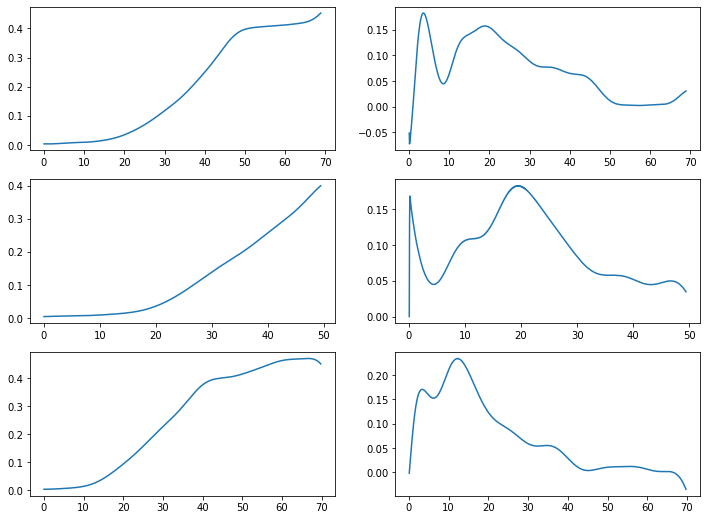

In [12]:
data_files = ['OD_15062020', 'OD_13072020', 'OD_27102020']
pyplot.rcParams['figure.figsize'] = (12, 9)
fig, axs = pyplot.subplots(len(data_files), 2)
for i,f in enumerate(data_files):
    df = pd.read_csv(f + ".csv", sep=',')
    kern = GPy.kern.RBF(1, lengthscale=10.0)
    gp = GPy.models.GPRegression(np.atleast_2d(df[time_label]).T, np.atleast_2d(df[od_label]).T, kernel=kern)
    gp.optimize()
    print("Data set from", f + ".csv")
    print(gp)
    time_grid = np.linspace(0, df[time_label][len(df)-1], num=1000)
    od_grid = np.interp(time_grid, df[time_label], gp.posterior.mean.flatten())
    mu = np.diff(od_grid) / (time_grid[1]-time_grid[0]) / od_grid[1:]
    axs[i, 0].plot(time_grid, od_grid)
    axs[i, 1].plot(time_grid[1:], mu)
    df_with_mu = df.copy()
    df_with_mu.insert(2, "Growth rate [1/h]", np.interp(df[time_label], time_grid[1:], mu))
    df_with_mu.to_csv(f + "_with_mu.csv")
